## O objetivo principal deste trabalho é tentar estabelecer uma conexão entre a cobertura vacinal em crianças estadunidenses ao longo dos anos e a taxa de mortalidade deste grupo populacional. Em particular, é de nosso interesse investigar se o movimento anti-vacina impactou a taxa de vacinação e se há um reflexo disso na mortalidade infantil.

# Importação dos pacotes relevantes

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leitura e limpeza do arquivo de vacinação

In [238]:
#Leitura geral do arquivo

#Lendo a segunda planilha
data_all_vac = pd.read_excel('survey-data_wuenic2024rev.xlsx', header=1, sheet_name=1)

print(data_all_vac.columns)

Index(['ISO3', 'surveyNameEnglish', 'surveyNameProduction', 'collectBegin',
       'collectEnd', 'cohortYear', 'vaccine', 'evidence', 'cardsSeen',
       'validity', 'ageVaccination', 'ageInterview', 'coverage',
       'denominator'],
      dtype='object')


In [239]:
#Filtrando apenas os dados dos EUA
data_vac = data_all_vac[data_all_vac["ISO3"] == "USA"]

print("Número de linhas e colunas:",data_vac.shape)
data_vac.head()

Número de linhas e colunas: (159, 14)


,ISO3,surveyNameEnglish,surveyNameProduction,collectBegin,collectEnd,cohortYear,vaccine,evidence,cardsSeen,validity,ageVaccination,ageInterview,coverage,denominator
45401,USA,National Immunization Survey 2002,National Immunization Survey 2002,2002-98,2002-98,2000,DTP3,Record or Recall,NaN,CRUDE,0-35 m,19-35 m,93.9,NaN
45402,USA,National Immunization Survey 2002,National Immunization Survey 2002,2002-98,2002-98,2000,HEPB3,Record or Recall,NaN,CRUDE,0-35 m,19-35 m,88.3,NaN
45403,USA,National Immunization Survey 2002,National Immunization Survey 2002,2002-98,2002-98,2000,MCV1,Record or Recall,NaN,CRUDE,0-35 m,19-35 m,91.3,NaN
45404,USA,National Immunization Survey 2002,National Immunization Survey 2002,2002-98,2002-98,2000,POL3,Record or Recall,NaN,CRUDE,0-35 m,19-35 m,89.8,NaN
45405,USA,National Immunization Survey (NIS) 2007,National Immunization Survey (NIS) 2007,2001-98,2003-98,2000,DTP3,Record,NaN,CRUDE,0-35 m,19-35 m,96.0,NaN


As colunas que nos interessam são: o ano em que a pesquisa foi feita, qual a vacina, a idade das crianças vacinadas e a cobertura vacinal.
Para determinar o ano da pesquisa, vamos fazer uma média do ano de início e final da coleta de dados e arredondar para o ano inteiro mais próximo (o -98 é um código para indicar que não se sabe o mês do ínicio ou final da coleta, assim collectBegin 2002-98 significa "início da coleta em um mês desconhecido de 2002").

In [240]:
data_vac = data_vac.copy()

#Fazendo a média do ano de início e fim da coleta
data_vac['collectBegin_year'] = data_vac['collectBegin'].astype(str).str.split("-").str[0].astype(float) #Pego apenas o que estiver antes do '-'
data_vac['collectEnd_year'] = data_vac['collectEnd'].astype(str).str.split("-").str[0].astype(float)

data_vac['collectYear_mean'] = data_vac[['collectBegin_year', 'collectEnd_year']].mean(axis=1) #Crio uma nova coluna com a média
data_vac['collectYear_mean'] = data_vac['collectYear_mean'].round(0).astype(float) #arredondando os anos

#Mantendo apenas as colunas que são de interesse
cols = ['collectYear_mean', 'vaccine', 'ageVaccination', 'coverage']
data_vac = data_vac[cols]

print("Número de linhas e colunas:", data_vac.shape)
print(data_vac.head())
print(data_vac.tail())

Número de linhas e colunas: (159, 4)
       collectYear_mean vaccine ageVaccination  coverage
45401            2002.0    DTP3         0-35 m      93.9
45402            2002.0   HEPB3         0-35 m      88.3
45403            2002.0    MCV1         0-35 m      91.3
45404            2002.0    POL3         0-35 m      89.8
45405            2002.0    DTP3         0-35 m      96.0
       collectYear_mean vaccine ageVaccination  coverage
45555            2022.0   HEPB3         0-35 m      91.1
45556            2022.0    PCV3         0-35 m      91.6
45557            2022.0    PCV4         0-35 m      80.7
45558            2022.0   ROTAC         0-35 m      75.1
45559            2022.0    FULL         0-35 m      66.9


In [241]:
#Verificando a consistência dos dados
np.unique(data_vac['ageVaccination'])

array(['0-23 m', '0-35 m'], dtype=object)

Essa inconsistência nos dados precisará ser levada em conta no decorrer da análise

In [242]:
#Verificando a existência de NaN's em alguma das colunas
data_vac.isna().any()

collectYear_mean    False
vaccine             False
ageVaccination      False
coverage            False
dtype: bool

In [243]:
#Verificando se existe alguma linha duplicada
data_vac.duplicated().any()

np.True_

In [244]:
#Verificando se existem anos com mais de um valor de cobertura para uma mesma vacina

duplicatas = (data_vac.groupby(['vaccine', 'collectYear_mean']).size().reset_index(name='contagem')) #agrupo todas as linhas com mesmo ano e vacina e conto

print(duplicatas[duplicatas['contagem'] > 1])


    vaccine  collectYear_mean  contagem
0      DTP3            2002.0         2
10     DTP3            2016.0         2
11     DTP3            2018.0         2
12     DTP3            2020.0         2
26     FULL            2016.0         2
27     FULL            2018.0         2
28     FULL            2020.0         2
31    HEPB3            2002.0         2
41    HEPB3            2016.0         2
42    HEPB3            2018.0         2
43    HEPB3            2020.0         2
48    HEPBB            2016.0         2
49    HEPBB            2018.0         2
50    HEPBB            2020.0         2
64     HIB3            2016.0         2
65     HIB3            2018.0         2
66     HIB3            2020.0         2
69     MCV1            2002.0         2
79     MCV1            2016.0         2
80     MCV1            2018.0         2
81     MCV1            2020.0         2
89     PCV3            2016.0         2
90     PCV3            2018.0         2
91     PCV3            2020.0         2


Para lidar com isso, vamos utilizar a média dos valores

In [245]:
data_vac = data_vac.copy()

data_vac = (data_vac.groupby(['collectYear_mean', 'vaccine', 'ageVaccination'], as_index=False)['coverage'].mean()) #faço a média das coberturas repetidas

data_vac.head()

,collectYear_mean,vaccine,ageVaccination,coverage
0,2002.0,DTP3,0-35 m,94.95
1,2002.0,FULL,0-35 m,72.50
2,2002.0,HEPB3,0-35 m,90.35
3,2002.0,HIB3,0-35 m,93.90
4,2002.0,MCV1,0-35 m,92.15


In [246]:
#Verificando a existência de valores faltantes
data_vac.isnull().any()

collectYear_mean    False
vaccine             False
ageVaccination      False
coverage            False
dtype: bool

Verificamos então que os dados estão prontos para serem usados

# Leitura e limpeza do arquivo de mortalidade infantil

In [247]:
#Leitura geral do arquivo

data_all_mor = pd.read_csv('UNICEF-CME_DF_2021_WQ-1.0-download.csv', header=0)

print("Número de linhas e colunas:",data_all_mor.shape)
data_all_mor.head()

Número de linhas e colunas: (56, 44)


,REF_AREA,Geographic area,INDICATOR,Indicator,SEX,Sex,WEALTH_QUINTILE,Wealth Quintile,SERIES_NAME,Series Name,...,DEFINITION,INTERVAL,SERIES_METHOD,Series Method,LOWER_BOUND,UPPER_BOUND,STATUS,YEAR_TO_ACHIEVE,MODEL,Model Used
0,USA,United States of America,MRM1T59,Mortality rate 1-59 months,_T,Total,_T,Total,UN_IGME,UN IGME estimate,...,NaN,1,NaN,NaN,8.837806,9.423883,NaN,NaN,NaN,NaN
1,USA,United States of America,MRM1T59,Mortality rate 1-59 months,_T,Total,_T,Total,UN_IGME,UN IGME estimate,...,NaN,1,NaN,NaN,8.498457,9.080405,NaN,NaN,NaN,NaN
2,USA,United States of America,MRM1T59,Mortality rate 1-59 months,_T,Total,_T,Total,UN_IGME,UN IGME estimate,...,NaN,1,NaN,NaN,8.073888,8.620468,NaN,NaN,NaN,NaN
3,USA,United States of America,MRM1T59,Mortality rate 1-59 months,_T,Total,_T,Total,UN_IGME,UN IGME estimate,...,NaN,1,NaN,NaN,7.779111,8.302203,NaN,NaN,NaN,NaN
4,USA,United States of America,MRM1T59,Mortality rate 1-59 months,_T,Total,_T,Total,UN_IGME,UN IGME estimate,...,NaN,1,NaN,NaN,7.680504,8.193784,NaN,NaN,NaN,NaN


In [248]:
print(data_all_mor.columns)

Index(['REF_AREA', 'Geographic area', 'INDICATOR', 'Indicator', 'SEX', 'Sex',
       'WEALTH_QUINTILE', 'Wealth Quintile', 'SERIES_NAME', 'Series Name',
       'SERIES_YEAR', 'Series Year', 'REGIONAL_GROUP', 'Regional group',
       'TIME_PERIOD', 'OBS_VALUE', 'COUNTRY_NOTES', 'CONNECTION',
       'DEATH_CATEGORY', 'CATEGORY', 'OBS_STATUS', 'Observation Status',
       'UNIT_MEASURE', 'Unit of measure', 'SERIES_CATEGORY', 'Series Category',
       'SERIES_TYPE', 'Series Type', 'STD_ERR', 'REF_DATE',
       'AGE_GROUP_OF_WOMEN', 'Age Group of Women', 'TIME_SINCE_FIRST_BIRTH',
       'Time Since First Birth', 'DEFINITION', 'INTERVAL', 'SERIES_METHOD',
       'Series Method', 'LOWER_BOUND', 'UPPER_BOUND', 'STATUS',
       'YEAR_TO_ACHIEVE', 'MODEL', 'Model Used'],
      dtype='object')


As colunas que nos interessam são: o indicador usado, o ano da pesquisa e a taxa de mortalidade.

Lembrando que a taxa de mortalidade é o número de mortes para cada 1000 crianças com um mês de idade.

In [249]:
#Fazendo a média dos limites da mortalidade

#Mantendo apenas as colunas que são de interesse
cols = ['Indicator', 'TIME_PERIOD', 'OBS_VALUE']
data_mor = data_all_mor[cols]

print("Número de linhas e colunas:", data_mor.shape)
data_mor.head()

Número de linhas e colunas: (56, 3)


,Indicator,TIME_PERIOD,OBS_VALUE
0,Mortality rate 1-59 months,1968-06,9.122363
1,Mortality rate 1-59 months,1969-06,8.781562
2,Mortality rate 1-59 months,1970-06,8.338982
3,Mortality rate 1-59 months,1971-06,8.038068
4,Mortality rate 1-59 months,1972-06,7.933614


Na prática, como estamos trabalhando em escalas de tempo relativamente grandes, podemos ignorar o mês da coleta de dados e considerar apenas o ano, assim 1968-06 (junho de 1968) se torna apenas 1968. Além disso, como os dados de imunização só contêm dados entre 2002 e 2022, os dados de outros anos não serão relevantes para este trabalho.

In [250]:
data_mor = data_mor.copy()

data_mor['TIME_PERIOD'] = data_mor['TIME_PERIOD'].astype(str).str.split("-").str[0].astype(float) #rmovendo o que vem depois do '-'
data_mor = data_mor[data_mor['TIME_PERIOD'].between(2002, 2022)] #removendo os dados de anos que não serão úteis

print("Número de linhas e colunas:", data_mor.shape)
print(data_mor.head())
print(data_mor.tail())

Número de linhas e colunas: (21, 3)
                     Indicator  TIME_PERIOD  OBS_VALUE
34  Mortality rate 1-59 months       2002.0   3.621801
35  Mortality rate 1-59 months       2003.0   3.539997
36  Mortality rate 1-59 months       2004.0   3.500696
37  Mortality rate 1-59 months       2005.0   3.490451
38  Mortality rate 1-59 months       2006.0   3.476488
                     Indicator  TIME_PERIOD  OBS_VALUE
50  Mortality rate 1-59 months       2018.0   2.775707
51  Mortality rate 1-59 months       2019.0   2.780986
52  Mortality rate 1-59 months       2020.0   2.841005
53  Mortality rate 1-59 months       2021.0   2.932978
54  Mortality rate 1-59 months       2022.0   3.036333


In [251]:
#Verificando a existência de NaN's em alguma das colunas
data_mor.isna().any()

Indicator      False
TIME_PERIOD    False
OBS_VALUE      False
dtype: bool

In [252]:
#Verificando se existe alguma linha duplicada
data_mor.duplicated().any()

np.False_

In [253]:
#Verificando a existência de valores faltantes
data_mor.isnull().any()

Indicator      False
TIME_PERIOD    False
OBS_VALUE      False
dtype: bool

Verificamos então que os dados estão prontos para serem usados

# Análise exploratória

Vamos fazer os gráficos das séries temporais da cobertura percentual de cada vacina

In [254]:
data_vac.head(10)

,collectYear_mean,vaccine,ageVaccination,coverage
0,2002.0,DTP3,0-35 m,94.95
1,2002.0,FULL,0-35 m,72.50
2,2002.0,HEPB3,0-35 m,90.35
3,2002.0,HIB3,0-35 m,93.90
4,2002.0,MCV1,0-35 m,92.15
5,2002.0,POL3,0-35 m,90.70
6,2003.0,DTP3,0-35 m,95.90
7,2003.0,FULL,0-35 m,76.00
8,2003.0,HEPB3,0-35 m,92.40
9,2003.0,HIB3,0-35 m,93.50


Conforme comentado anteriormente, há uma inconsistência nos dados da idade das crianças cuja cobertura vacinal está sendo analisada.

In [255]:
aux1 = data_vac[data_vac['ageVaccination'] == '0-35 m'].index.tolist()
aux2 = data_vac[data_vac['ageVaccination'] == '0-23 m'].index.tolist()

print(f'Anos com os dados de crianças de 0-35 meses: {np.unique(data_vac.loc[aux1, 'collectYear_mean'])}')
print(f'Anos com os dados de crianças de 0-23 meses: {np.unique(data_vac.loc[aux2, 'collectYear_mean'])}')

Anos com os dados de crianças de 0-35 meses: [2002. 2003. 2004. 2005. 2006. 2007. 2011. 2016. 2018. 2020. 2021. 2022.]
Anos com os dados de crianças de 0-23 meses: [2012. 2013. 2014.]


Para lidar com isso, vamos fazer as séries temporais prestando atenção a esse recorte temporal para vermos se há alguma discrepância significativa.

Precisamos também verificar se em todos os anos foram registradas as informações das mesmas vacinas ou se há discrepância.

In [256]:
vacinas_por_ano = data_vac.groupby('collectYear_mean')['vaccine'].unique() #agrupa as informações com base nos anos de coleta

print(vacinas_por_ano)

collectYear_mean
2002.0                [DTP3, FULL, HEPB3, HIB3, MCV1, POL3]
2003.0                [DTP3, FULL, HEPB3, HIB3, MCV1, POL3]
2004.0                [DTP3, FULL, HEPB3, HIB3, MCV1, POL3]
2005.0                [DTP3, FULL, HEPB3, HIB3, MCV1, POL3]
2006.0                [DTP3, FULL, HEPB3, HIB3, MCV1, POL3]
2007.0          [DTP3, FULL, HEPB3, HIB3, MCV1, PCV3, POL3]
2011.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2012.0    [DTP3, FULL, HEPB3, HIB3, MCV1, PCV3, POL3, RO...
2013.0    [DTP3, FULL, HEPB3, HIB3, MCV1, PCV3, POL3, RO...
2014.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2016.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2018.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2020.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2021.0    [DTP3, FULL, HEPB3, HEPBB, HIB3, MCV1, PCV3, P...
2022.0    [DTP3, DTP4, FULL, HEPB3, HEPBB, HIB2, HIB3, M...
Name: vaccine, dtype: object


Como podemos ver, não há padronização e, para lidar com isso, vamos pegar apenas os dados das vacinas que aparecem em todos os anos.

In [257]:
vacinas_comuns = set(vacinas_por_ano.iloc[0]) #inicia o conjunto pelas vacinas do primeiro ano da lista

for v in vacinas_por_ano: #percorre as vacinas de cada ano
    vacinas_comuns &= set(v) #faz a intersecção entre os conjuntos

print(vacinas_comuns)

{'HIB3', 'POL3', 'HEPB3', 'FULL', 'MCV1', 'DTP3'}


Além disso, também não temos interesse em olhar os dados das linhas de cobertura vacinal completa: queremos analisar cada vacina detalhadamente.

In [258]:
data_vac = data_vac.copy()

data_vac = data_vac[data_vac['vaccine'].isin(vacinas_comuns)  & (data_vac['vaccine'] != 'FULL')] #pega apenas os dados das vacinas em comum e tirando a cobertura completa

data_vac.head(10)

,collectYear_mean,vaccine,ageVaccination,coverage
0,2002.0,DTP3,0-35 m,94.95
2,2002.0,HEPB3,0-35 m,90.35
3,2002.0,HIB3,0-35 m,93.90
4,2002.0,MCV1,0-35 m,92.15
5,2002.0,POL3,0-35 m,90.70
6,2003.0,DTP3,0-35 m,95.90
8,2003.0,HEPB3,0-35 m,92.40
9,2003.0,HIB3,0-35 m,93.50
10,2003.0,MCV1,0-35 m,93.00
11,2003.0,POL3,0-35 m,91.60


Por fim, façamos as séries temporais:

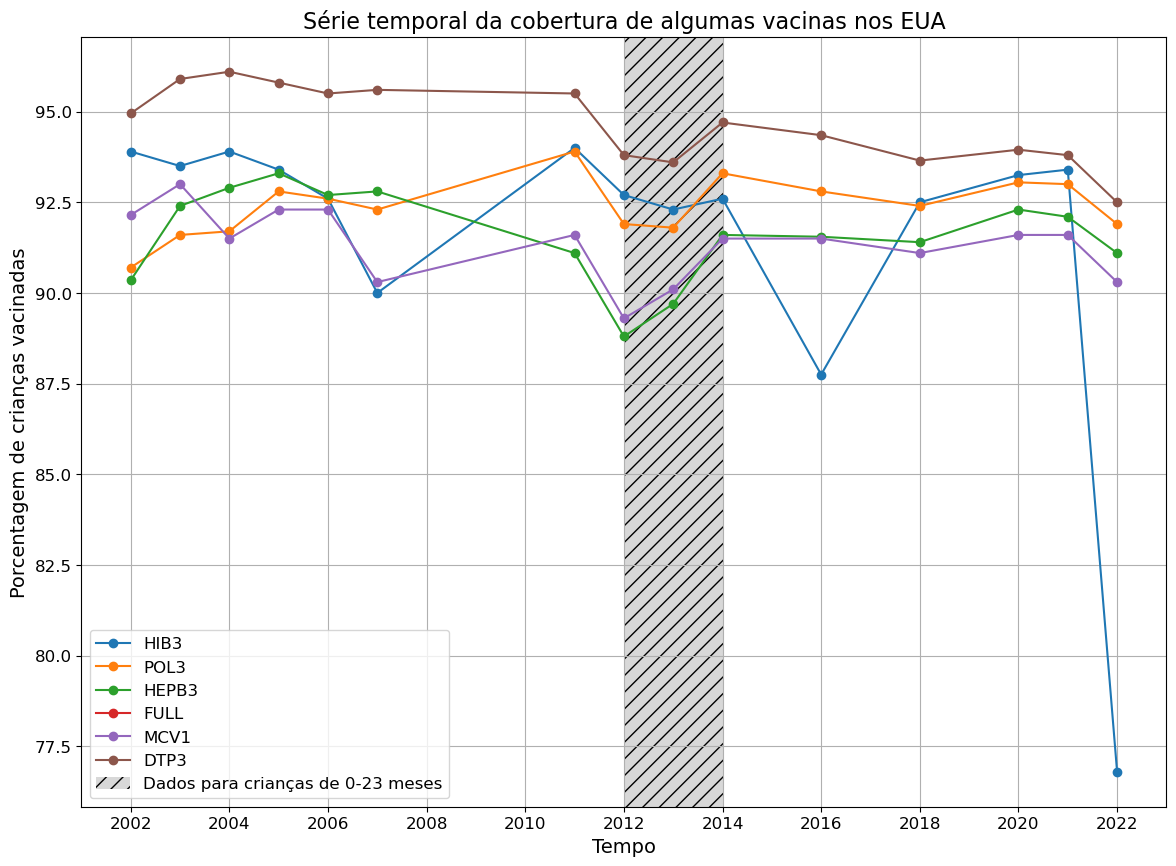

In [259]:
plt.figure(figsize=(14,10))

for vacina in vacinas_comuns:
  dados = data_vac[data_vac['vaccine'] == vacina]
  tempo = dados['collectYear_mean'].astype(int)
  cobertura = dados['coverage']
  plt.plot(tempo, cobertura, 'o-', label=vacina)

plt.axvspan(2012, 2014, ymin=0, ymax=1, facecolor='gray', alpha=0.3, hatch='//', label='Dados para crianças de 0-23 meses')

plt.xlabel("Tempo",fontsize = 14)
plt.ylabel("Porcentagem de crianças vacinadas", fontsize = 14)
plt.xticks(range(int(data_vac['collectYear_mean'].min()), int(data_vac['collectYear_mean'].max())+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'Série temporal da cobertura de algumas vacinas nos EUA', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

Podemos perceber que na região em que os dados são para crianças de 0-23 meses há uma queda percentual em todas as vacinas em relação aos valores para crianças de 0-35 meses. Precisaremos lidar com isso.

Vamos agora fazer a série temporal da mortalidade infantil.

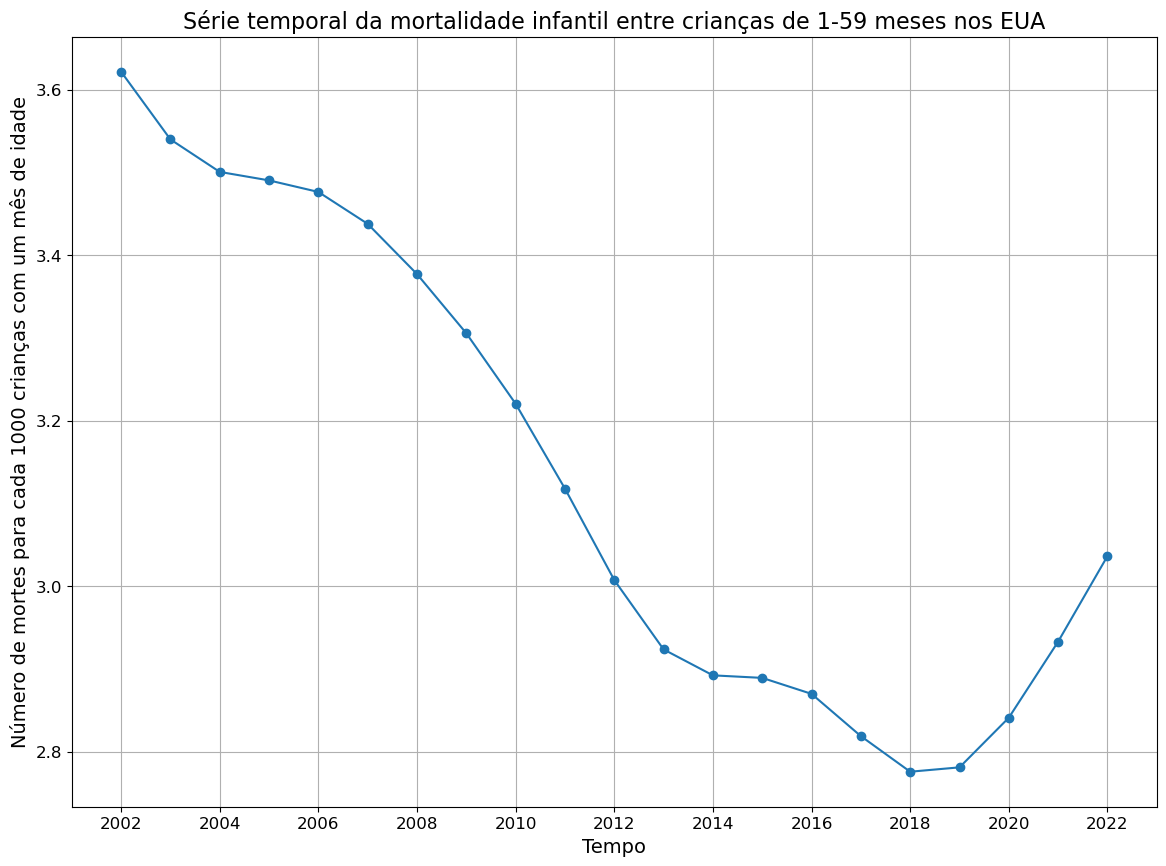

In [260]:
plt.figure(figsize=(14,10))

tempo = data_mor['TIME_PERIOD'].astype(int)
mortalidade = data_mor['OBS_VALUE']

plt.plot(tempo, mortalidade, 'o-')

plt.xlabel("Tempo",fontsize = 14)
plt.ylabel("Número de mortes para cada 1000 crianças com um mês de idade", fontsize = 14)
plt.xticks(range(int(data_mor['TIME_PERIOD'].min()), int(data_mor['TIME_PERIOD'].max())+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'Série temporal da mortalidade infantil entre crianças de 1-59 meses nos EUA', fontsize=16)
plt.grid(True)

plt.show()

## Correlação

Para estabelecer a correlação entre uma vacina ou todas com a taxa de mortalidade devemos, primeiro, tratar do problema da diferença da base de dados que ocorre nos anos de 2012-2014.

Tentaremos duas abordagens:
*   Apenas excluir os dados destes anos
*   Fazer uma regressão linear para os dados destes anos

### Dados **apenas** filtrados

#### Filtramos os dados para os dados que utilizam a vacinação no período de '0-35 m'

In [261]:
# Criamos uma cópia para não alterar o DataFrame original
data_vac_filtered = data_vac[data_vac['ageVaccination'] == '0-35 m'].copy()

print("Anos restantes após a filtragem:", sorted(data_vac_filtered['collectYear_mean'].unique()))

Anos restantes após a filtragem: [np.float64(2002.0), np.float64(2003.0), np.float64(2004.0), np.float64(2005.0), np.float64(2006.0), np.float64(2007.0), np.float64(2011.0), np.float64(2016.0), np.float64(2018.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0)]


Definimos as categorias

In [262]:
# Definindo as categorias de risco
vacinas_agudas = ['DTP3', 'HIB3', 'MCV1', 'POL3']
vacinas_cronicas = ['HEPB3']
vacinas = ['DTP3', 'HIB3', 'MCV1', 'POL3', 'HEPB3']

print("\nCategorias definidas:")
print(f"- Risco Agudo: {vacinas_agudas}")
print(f"- Risco Crônico: {vacinas_cronicas}")


Categorias definidas:
- Risco Agudo: ['DTP3', 'HIB3', 'MCV1', 'POL3']
- Risco Crônico: ['HEPB3']


Unificamos mortalidade e vacinação em um único dataframe

In [263]:
# Usamos os anos da mortalidade como base para o índice
df_corr_filt = pd.DataFrame(index=sorted(data_mor['TIME_PERIOD'].unique()))
df_corr_filt.index.name = 'Year'

# Adicionando a taxa de mortalidade (agrupando por ano para garantir um valor único)
df_corr_filt['Mortalidade_Infantil'] = data_mor.groupby('TIME_PERIOD')['OBS_VALUE'].mean()

# Adicionando as coberturas vacinais do nosso conjunto filtrado
for vacina in vacinas_comuns:
    if vacina == 'FULL': continue

    # Pegamos a média anual da cobertura para a vacina atual
    dados_vacina = data_vac_filtered[data_vac_filtered['vaccine'] == vacina].groupby('collectYear_mean')['coverage'].mean()
    # Adicionamos essa série ao nosso DataFrame unificado
    df_corr_filt[vacina] = dados_vacina

# Visualizando as primeiras linhas para ver os NaNs (valores vazios)
print("Primeiras 5 linhas do DataFrame unificado (antes da limpeza):")
display(df_corr_filt.head())

Primeiras 5 linhas do DataFrame unificado (antes da limpeza):


,Mortalidade_Infantil,HIB3,POL3,HEPB3,MCV1,DTP3
Year,,,,,,
2002.0,3.621801,93.9,90.7,90.35,92.15,94.95
2003.0,3.539997,93.5,91.6,92.40,93.00,95.90
2004.0,3.500696,93.9,91.7,92.90,91.50,96.10
2005.0,3.490451,93.4,92.8,93.30,92.30,95.80
2006.0,3.476488,92.6,92.6,92.70,92.30,95.50


Limpamos os dados vazios e calculamos as médias por categoria

In [264]:
# Removemos qualquer linha que tenha pelo menos um valor NaN (nulo)
df_corr_filt.dropna(inplace=True)

print(f"Anos restantes para análise de correlação: {len(df_corr_filt)}")

# Identificamos quais colunas de vacinas realmente existem no nosso DataFrame final
cols_agudas_filt = [v for v in vacinas_agudas if v in df_corr_filt.columns]
cols_cronicas_filt = [v for v in vacinas_cronicas if v in df_corr_filt.columns]
cols_todas_filt = [v for v in vacinas if v in df_corr_filt.columns]

# Calculamos a média anual para cada grupo de vacinas
df_corr_filt['Media_Cobertura_Agudo'] = df_corr_filt[cols_agudas_filt].mean(axis=1)
df_corr_filt['Media_Cobertura_Cronico'] = df_corr_filt[cols_cronicas_filt].mean(axis=1)
df_corr_filt['Media_Cobertura'] = df_corr_filt[cols_todas_filt].mean(axis=1)

# Mostrando as primeiras linhas já limpas e com as médias
print("\nDataFrame pronto para correlação (primeiras 5 linhas):")
display(df_corr_filt.head())

Anos restantes para análise de correlação: 12

DataFrame pronto para correlação (primeiras 5 linhas):


,Mortalidade_Infantil,HIB3,POL3,HEPB3,MCV1,DTP3,Media_Cobertura_Agudo,Media_Cobertura_Cronico,Media_Cobertura
Year,,,,,,,,,
2002.0,3.621801,93.9,90.7,90.35,92.15,94.95,92.925,90.35,92.41
2003.0,3.539997,93.5,91.6,92.40,93.00,95.90,93.500,92.40,93.28
2004.0,3.500696,93.9,91.7,92.90,91.50,96.10,93.300,92.90,93.22
2005.0,3.490451,93.4,92.8,93.30,92.30,95.80,93.575,93.30,93.52
2006.0,3.476488,92.6,92.6,92.70,92.30,95.50,93.250,92.70,93.14


Calculamos e exibimos a matriz de correlação

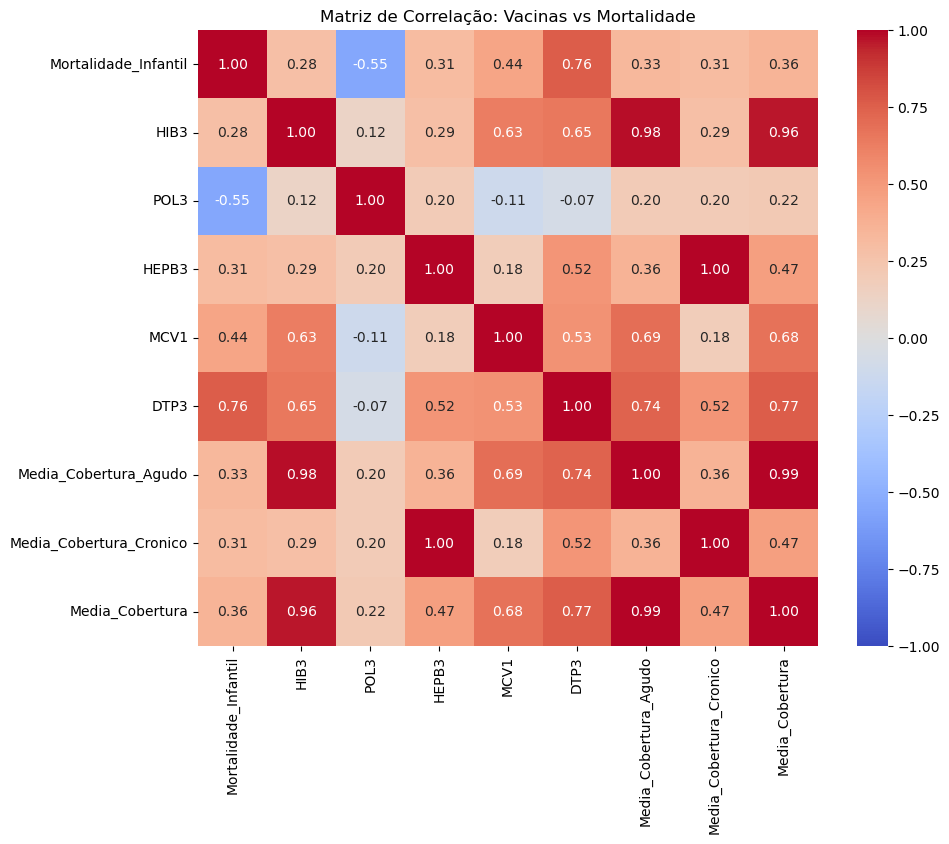

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a matriz de correlação de Pearson
matriz_corr = df_corr_filt.corr()

# Cria uma figura para o gráfico
plt.figure(figsize=(10, 8))

# Gera o heatmap
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

plt.title('Matriz de Correlação: Vacinas vs Mortalidade')
plt.show()

Exibimos a correlação individual e das médias

In [266]:
print("\n=== Resultados da Correlação (Método: Filtragem) ===")
print("Valores próximos de -1 indicam que maior cobertura vacinal está fortemente associada a menor mortalidade.\n")

print("--- Correlação por Vacina Individual ---")
for vacina in cols_agudas_filt + cols_cronicas_filt:
    # Obtemos o valor da correlação específico entre a vacina e a mortalidade
    corr_valor = matriz_corr.loc[vacina, 'Mortalidade_Infantil']
    tipo = "Agudo" if vacina in vacinas_agudas else "Crônico"
    print(f"{vacina:5} ({tipo:7}): {corr_valor:.4f}")

print("\n--- Correlação por Média de Categoria ---")
# Exibimos a correlação das médias agregadas
corr_agudo = matriz_corr.loc['Media_Cobertura_Agudo', 'Mortalidade_Infantil']
corr_cronico = matriz_corr.loc['Media_Cobertura_Cronico', 'Mortalidade_Infantil']
corr_todas = matriz_corr.loc['Media_Cobertura', 'Mortalidade_Infantil']

print(f"Média Cobertura (Risco Agudo)   vs Mortalidade: {corr_agudo:.4f}")
print(f"Média Cobertura (Risco Crônico) vs Mortalidade: {corr_cronico:.4f}")
print(f"Média Cobertura (Todas) vs Mortalidade: {corr_todas:.4f}")


=== Resultados da Correlação (Método: Filtragem) ===
Valores próximos de -1 indicam que maior cobertura vacinal está fortemente associada a menor mortalidade.

--- Correlação por Vacina Individual ---
DTP3  (Agudo  ): 0.7633
HIB3  (Agudo  ): 0.2813
MCV1  (Agudo  ): 0.4401
POL3  (Agudo  ): -0.5521
HEPB3 (Crônico): 0.3066

--- Correlação por Média de Categoria ---
Média Cobertura (Risco Agudo)   vs Mortalidade: 0.3348
Média Cobertura (Risco Crônico) vs Mortalidade: 0.3066
Média Cobertura (Todas) vs Mortalidade: 0.3568


Por esta análise, apenas a POL3 está correlacionada à baixa mortalidade infantil. Por outro lado, a DTP3 está fortemente correlacionada à alta mortalidade infantil.
Além disso, nada se pode aferir quanto aos grupos estabelecidos --- pois ambos tem uma correlação similar

#### Filtramos os dados para os dados que utilizam a vacinação no período de '0-23 m'

In [267]:
# Criamos uma cópia para não alterar o DataFrame original
data_vac_filtered = data_vac[data_vac['ageVaccination'] == '0-23 m'].copy()

print("Anos restantes após a filtragem:", sorted(data_vac_filtered['collectYear_mean'].unique()))

Anos restantes após a filtragem: [np.float64(2012.0), np.float64(2013.0), np.float64(2014.0)]


Definimos as categorias

In [268]:
# Definindo as categorias de risco
vacinas_agudas = ['DTP3', 'HIB3', 'MCV1', 'POL3']
vacinas_cronicas = ['HEPB3']
vacinas = ['DTP3', 'HIB3', 'MCV1', 'POL3', 'HEPB3']

print("\nCategorias definidas:")
print(f"- Risco Agudo: {vacinas_agudas}")
print(f"- Risco Crônico: {vacinas_cronicas}")


Categorias definidas:
- Risco Agudo: ['DTP3', 'HIB3', 'MCV1', 'POL3']
- Risco Crônico: ['HEPB3']


Unificamos mortalidade e vacinação em um único dataframe

In [269]:
# Usamos os anos da mortalidade como base para o índice
df_corr_filt = pd.DataFrame(index=sorted(data_mor['TIME_PERIOD'].unique()))
df_corr_filt.index.name = 'Year'

# Adicionando a taxa de mortalidade (agrupando por ano para garantir um valor único)
df_corr_filt['Mortalidade_Infantil'] = data_mor.groupby('TIME_PERIOD')['OBS_VALUE'].mean()

# Adicionando as coberturas vacinais do nosso conjunto filtrado
for vacina in vacinas_comuns:
    if vacina == 'FULL': continue

    # Pegamos a média anual da cobertura para a vacina atual
    dados_vacina = data_vac_filtered[data_vac_filtered['vaccine'] == vacina].groupby('collectYear_mean')['coverage'].mean()
    # Adicionamos essa série ao nosso DataFrame unificado
    df_corr_filt[vacina] = dados_vacina

# Visualizando as primeiras linhas para ver os NaNs (valores vazios)
print("Primeiras 5 linhas do DataFrame unificado (antes da limpeza):")
display(df_corr_filt.head())

Primeiras 5 linhas do DataFrame unificado (antes da limpeza):


,Mortalidade_Infantil,HIB3,POL3,HEPB3,MCV1,DTP3
Year,,,,,,
2002.0,3.621801,NaN,NaN,NaN,NaN,NaN
2003.0,3.539997,NaN,NaN,NaN,NaN,NaN
2004.0,3.500696,NaN,NaN,NaN,NaN,NaN
2005.0,3.490451,NaN,NaN,NaN,NaN,NaN
2006.0,3.476488,NaN,NaN,NaN,NaN,NaN


Limpamos os dados vazios e calculamos as médias por categoria

In [270]:
# Removemos qualquer linha que tenha pelo menos um valor NaN (nulo)
df_corr_filt.dropna(inplace=True)

print(f"Anos restantes para análise de correlação: {len(df_corr_filt)}")

# Identificamos quais colunas de vacinas realmente existem no nosso DataFrame final
cols_agudas_filt = [v for v in vacinas_agudas if v in df_corr_filt.columns]
cols_cronicas_filt = [v for v in vacinas_cronicas if v in df_corr_filt.columns]
cols_todas_filt = [v for v in vacinas if v in df_corr_filt.columns]

# Calculamos a média anual para cada grupo de vacinas
df_corr_filt['Media_Cobertura_Agudo'] = df_corr_filt[cols_agudas_filt].mean(axis=1)
df_corr_filt['Media_Cobertura_Cronico'] = df_corr_filt[cols_cronicas_filt].mean(axis=1)
df_corr_filt['Media_Cobertura'] = df_corr_filt[cols_todas_filt].mean(axis=1)

# Mostrando as primeiras linhas já limpas e com as médias
print("\nDataFrame pronto para correlação (primeiras 5 linhas):")
display(df_corr_filt.head())

Anos restantes para análise de correlação: 3

DataFrame pronto para correlação (primeiras 5 linhas):


,Mortalidade_Infantil,HIB3,POL3,HEPB3,MCV1,DTP3,Media_Cobertura_Agudo,Media_Cobertura_Cronico,Media_Cobertura
Year,,,,,,,,,
2012.0,3.007401,92.7,91.9,88.8,89.3,93.8,91.925,88.8,91.30
2013.0,2.923535,92.3,91.8,89.7,90.1,93.6,91.950,89.7,91.50
2014.0,2.892191,92.6,93.3,91.6,91.5,94.7,93.025,91.6,92.74


Calculamos e exibimos a matriz de correlação

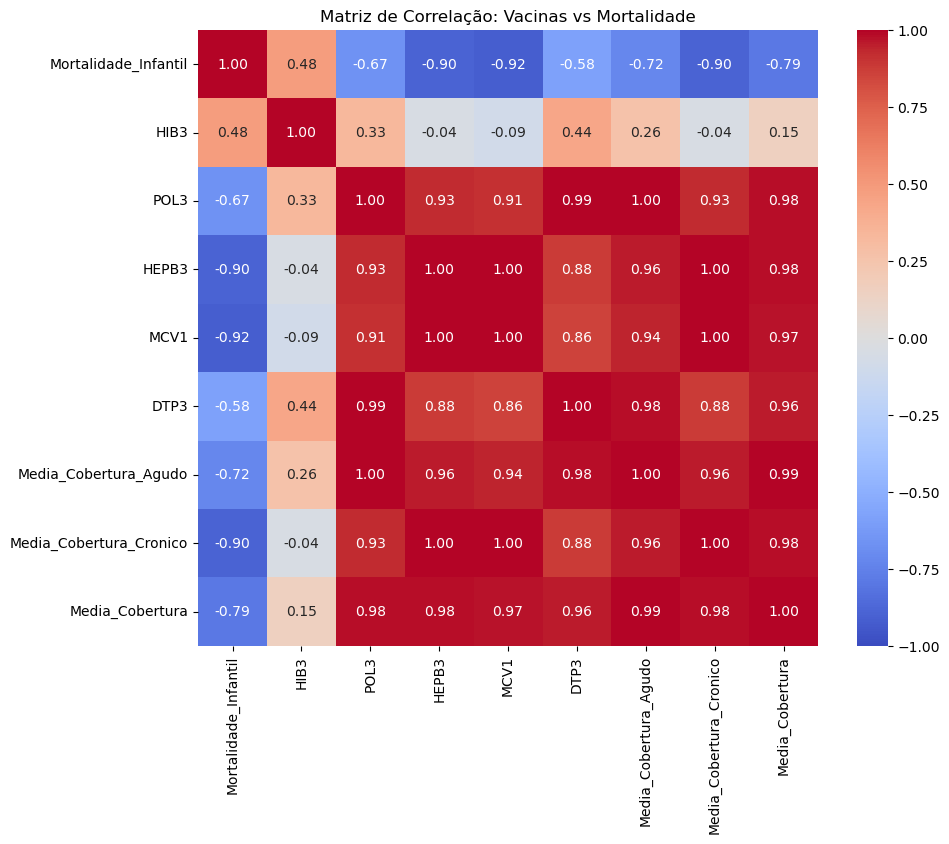

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a matriz de correlação de Pearson
matriz_corr = df_corr_filt.corr()

# Cria uma figura para o gráfico
plt.figure(figsize=(10, 8))

# Gera o heatmap
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

plt.title('Matriz de Correlação: Vacinas vs Mortalidade')
plt.show()

Exibimos a correlação individual e das médias

In [272]:
print("\n=== Resultados da Correlação (Método: Filtragem) ===")
print("Valores próximos de -1 indicam que maior cobertura vacinal está fortemente associada a menor mortalidade.\n")

print("--- Correlação por Vacina Individual ---")
for vacina in cols_agudas_filt + cols_cronicas_filt:
    # Obtemos o valor da correlação específico entre a vacina e a mortalidade
    corr_valor = matriz_corr.loc[vacina, 'Mortalidade_Infantil']
    tipo = "Agudo" if vacina in vacinas_agudas else "Crônico"
    print(f"{vacina:5} ({tipo:7}): {corr_valor:.4f}")

print("\n--- Correlação por Média de Categoria ---")
# Exibimos a correlação das médias agregadas
corr_agudo = matriz_corr.loc['Media_Cobertura_Agudo', 'Mortalidade_Infantil']
corr_cronico = matriz_corr.loc['Media_Cobertura_Cronico', 'Mortalidade_Infantil']
corr_todas = matriz_corr.loc['Media_Cobertura', 'Mortalidade_Infantil']

print(f"Média Cobertura (Risco Agudo)   vs Mortalidade: {corr_agudo:.4f}")
print(f"Média Cobertura (Risco Crônico) vs Mortalidade: {corr_cronico:.4f}")
print(f"Média Cobertura (Todas) vs Mortalidade: {corr_todas:.4f}")


=== Resultados da Correlação (Método: Filtragem) ===
Valores próximos de -1 indicam que maior cobertura vacinal está fortemente associada a menor mortalidade.

--- Correlação por Vacina Individual ---
DTP3  (Agudo  ): -0.5797
HIB3  (Agudo  ): 0.4794
MCV1  (Agudo  ): -0.9157
POL3  (Agudo  ): -0.6670
HEPB3 (Crônico): -0.8957

--- Correlação por Média de Categoria ---
Média Cobertura (Risco Agudo)   vs Mortalidade: -0.7241
Média Cobertura (Risco Crônico) vs Mortalidade: -0.8957
Média Cobertura (Todas) vs Mortalidade: -0.7946
